## Sztuczne sieci neuronowe - laboratorium 4

### Sieci neuronowe

Podczas poprzednich dwóch ćwiczeń:
- poszukiwaliśmy parametrów **modelu liniowego**, aby dopasować go do danych
- zdefiniowaliśmy funkcję straty dla regresji - błąd średniokwardratowy (MSE)
- użyliśmy algorytmu najszybszego spadku, aby znaleźć optymalne parametry modelu
- najpierw robiliśmy wsystkie te kroki "ręcznie", potem poznaliśmy możliwości PyTorch autograd i torch.optim.

Dziś zastąpimy model liniowy prostą siecią neuronową.

**Sieć neuronowa** to przykład modelu bardziej złożonego niż model liniowy. 

Algorytmy uczenia sieci neuronowych nie różnią się jednak szczególnie od poznanych już na zajęciach - powszechnie stosuje się algorytm najszybszego spadku lub jeden z jego bardziej zaawansowanych wariantów (SGD+momentum, Adagrad, RMSProp, Adam, ...).

Podstawowym składnikiem sieci neuronowej jest **neuron**.
Równanie neuronu można zapisać jako `o = f(w * x + b)`, gdzie `x` to dane wejściowe, `w` i `b` to parametry (wagi), a `f` to funkcja aktywacji. Neurony składają się na **warstwy** tworzące sieć neuronową.

Najpierw wrócimy jednak do modelu liniowego.

#### dane studenta: Natalia Chostenko

In [64]:
import torch
import torch.nn as nn
import torch.optim as optim

In [65]:
data_unknown = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
data_celsius = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]

t_u = torch.tensor(data_unknown)
t_c = torch.tensor(data_celsius)

t_u_mean = t_u.mean()
t_u_std = t_u.std()

t_un = (t_u - t_u_mean) / t_u_std

### Zbiór uczący i walidacyjny

Zadaniem modelu nie jest zapamiętanie danych uczących, ale nauczenie się wzorców, które "poradzą sobie" także z przykładami niewidzianymi podczas treningu. Zbiór danych - w przypadku walidacji prostej - należy podzielić na dwa podzbiory, a następnie uczyć model na jednym z nich (zbiór uczący) i sprawdzać jego działanie na innym (zbiór walidacyjny/testowy).

#### Ćwiczenie
Podziel zbiór danych na zbiór uczący i walidacyjny, losując 20% elementów (na podstawie ich indeksów) tensora `t_un` do zbioru walidacyjnego. Wykorzystaj funkcję `torch.randperm`.

https://pytorch.org/docs/stable/generated/torch.randperm.html

Przypisz podzielone tensory `t_u`, `t_un` i `t_c` do zmiennych `train_t_u`, `val_t_u` itd.

In [76]:
# rozmiar zbioru walidacyjnego 20 procent 
n_val = int(0.2 * n_samples)

# losowanie z użyciem randperm
shuffled_indices = torch.randperm(n_samples)

# zbior uczacy i walidacyjny
train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

# przypisanie tensorow do zmiennych
train_t_u = t_u[train_indices]
val_t_u = t_u[val_indices]

train_t_c = t_c[train_indices]
val_t_c = t_c[val_indices]

train_t_un = t_un[train_indices]
val_t_un = t_un[val_indices]

print("t_u")
print(train_t_u)
print(val_t_u)


print("t_un")
print(train_t_un)
print(val_t_un)


print("t_c")
print(train_t_c)
print(val_t_c)


t_u
tensor([48.4000, 68.4000, 48.9000, 21.8000, 55.9000, 58.2000, 33.9000, 35.7000,
        60.4000])
tensor([81.9000, 56.3000])
t_un
tensor([-0.2020,  0.9862, -0.1723, -1.7823,  0.2436,  0.3802, -1.0635, -0.9565,
         0.5109])
tensor([1.7883, 0.2673])
t_c
tensor([ 6.0000, 21.0000,  8.0000, -4.0000, 14.0000, 15.0000,  3.0000,  0.5000,
        13.0000])
tensor([28., 11.])


#### Pętla treningowa - walidacja modelu

W procesie poszukiwania parametrów modelu dokonujemy aktualizacji parametrów modelu na podstawie funkcji straty dla zbioru uczącego. Należy także monitorować funkcję straty na zbiorze walidacyjnym, na przykład w celu uniknięcia przeuczenia modelu.

Jako że na zbiorze walidacyjnym nie musimy wykonywać kroku "wstecz", nie wywołujemy `val_loss.backward()`. W związku z tym nie ma potrzeby budowania grafu - w celu przyspieszenia obliczeń fragmenty kodu związane z walidacją możemy zamknąć w bloku `with torch.no_grad()`.

In [77]:
def training_loop(n_epochs, optimizer, params, train_t_u, val_t_u, train_t_c, val_t_c):
    for epoch in range(1, n_epochs + 1):
        train_t_p = model(train_t_u, *params)
        train_loss = loss_fn(train_t_p, train_t_c)
        with torch.no_grad():
            val_t_p = model(val_t_u, *params)
            val_loss = loss_fn(val_t_p, val_t_c)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

### torch.nn

https://pytorch.org/docs/stable/nn.html

Moduł PyTorcha `torch.nn` zawiera implementacje różnych elementów (warstw) tworzących sieci neuronowe. Elementy te w PyTorchu nazywa się modułami ("modules") - realizowane są jako klasy dziedziczące po klasie bazowej `nn.Module`.

Najprostszym przykładem modułu jest warstwa liniowa (gęsta) `nn.Linear`, która jest równoważna modelowi liniowemu (funkcja `model`) z przykładu z termometrami z poprzednich ćwiczeń.

Konstruktor `nn.Linear` przyjmuje 3 argumenty - rozmiar wejścia (liczbę cech - oraz przypisanych im wag `w`), rozmiar wyjścia oraz argument True/False, czy uwzględniać wyraz wolny (`b`) - domyślnie True.

https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear

### Ćwiczenie

Stwórz model liniowy używając modułu `nn.Linear`. Poeksperymentuj z różnymi wartościami argumentów konstruktora: `in_features`, `out_features` oraz `bias`. Zobacz, jak zmienia się zawartość atrybutów `linear_model.weight` i `linear_model.bias`. Sprawdź zawartość `list(model.parameters())`.

In [84]:
# wartosci oryginalne
linear_model = nn.Linear(in_features=1, out_features=1, bias=True)
print(f'poczatkowe wagi {linear_model.weight}')
print(f'bias numer 1 {linear_model.bias}\n')

#2
linear_model_2 = nn.Linear(in_features=3, out_features=2, bias=False)
print(f'wagi bez biasu {linear_model_2.weight}\n')

#3
linear_model_3 = nn.Linear(in_features=2, out_features=3, bias=True)
print(f'wagi modelu z innymi argumentami {linear_model_3.weight}')
print(f'bias z innymi argumentami {linear_model_3.bias}\n')

# zawartosc list dla ostatniego modelu
parameters_list = list(linear_model_3.parameters())
print(f'lista parametrów modelu nr 3 {parameters_list}')


poczatkowe wagi Parameter containing:
tensor([[-0.8873]], requires_grad=True)
bias numer 1 Parameter containing:
tensor([-0.6880], requires_grad=True)

wagi bez biasu Parameter containing:
tensor([[-0.4735,  0.4043,  0.1500],
        [ 0.1435,  0.1577, -0.3418]], requires_grad=True)

wagi modelu z innymi argumentami Parameter containing:
tensor([[ 0.4488, -0.0167],
        [-0.5133, -0.2629],
        [-0.0664, -0.2880]], requires_grad=True)
bias z innymi argumentami Parameter containing:
tensor([-0.2757, -0.4886,  0.6310], requires_grad=True)

lista parametrów modelu nr 3 [Parameter containing:
tensor([[ 0.4488, -0.0167],
        [-0.5133, -0.2629],
        [-0.0664, -0.2880]], requires_grad=True), Parameter containing:
tensor([-0.2757, -0.4886,  0.6310], requires_grad=True)]


#### Ćwiczenie
W przypadku "wrzucania" do modelu wielu (N) obserwacji jednocześnie (tzw. batch danych) należy zadbać o odpowiednie wymiary tensora (tu: tensor kolumnowy N x 1). W tym celu należy użyć funkcji `unsqueeze`.

https://pytorch.org/docs/stable/generated/torch.unsqueeze.html

Sprawdź, jaką wartość ma atrybut `.shape` tensora `t_un` przed i po użyciu funkcji `unsqueeze`.

Następnie przepuść tensor zawierający znormalizowane dane wejściowe przez model (dobierz odpowiednie rozmiary wejścia i wyjścia `nn.Linear`). W tym celu można po prostu wywołać `model(dane_wejsciowe)` - jest to wywołanie metody `__call__` klasy `nn.Linear`.

In [9]:
# ksztalt przed unsqueeze
print(f'oryginalny ksztalt {t_un.shape}')

# dodanie nowego wymiaru
t_un_unsqueezed = t_un.unsqueeze(1)

print(f'ksztalt po unsqueeze {t_un_unsqueezed.shape}\n')

oryginalny ksztalt torch.Size([11])
ksztalt po unsqueeze torch.Size([11, 1])



In [10]:
# model liniowy
linear_model = nn.Linear(in_features=1, out_features=1)

# przepuszczenie znormalizowanych danych przez model
t_un_normalized = 0.1 * t_un_unsqueezed  # normalizacja
predicted_t_c = linear_model(t_un_normalized)

print(f'przewidziane wartosci na wyjsciu \n{predicted_t_c}')

przewidziane wartosci na wyjsciu 
tensor([[-0.4427],
        [-0.4029],
        [-0.3984],
        [-0.3517],
        [-0.4021],
        [-0.4167],
        [-0.4462],
        [-0.4700],
        [-0.4177],
        [-0.3941],
        [-0.3783]], grad_fn=<AddmmBackward0>)


#### Ćwiczenie

Uzupełnij poniższe komórki:
- uzupełnij funkcję `training_loop_torch_nn`
- zainicjalizuj model liniowy i optymalizator SGD dla learning rate 0.01
- następnie wywołaj ją dla 1000 iteracji (epok)

`torch.nn` zawiera także implementacje różnych funkcji straty. Przy wywołaniu pętli treningowej podaj funkcję straty `nn.MSELoss()`.

Po wywołaniu pętli uczącej zajrzyj w parametry modelu - atrybuty `.weight` i `.bias`



In [46]:
# ZASTĄP SŁOWA None KODEM / DOPISZ LINIE KODU WE WSKAZANYCH MIEJSCACH

def training_loop_torch_nn(n_iters, optimizer, model, loss_fn, train_t_u, val_t_u, train_t_c, val_t_c, verbose=True):
    for iteration in range(n_iters+1):    
        train_t_p = model(train_t_u)
        loss_train = loss_fn(train_t_p, train_t_c)
        
        with torch.no_grad():
            val_t_p = model(val_t_u)
            loss_val = loss_fn(val_t_p, val_t_c)
            
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        
        if verbose and iteration % 100 == 0: #zmiana zeby nie wypisywac wszystkiego
            print('Epoch %d, Training loss %f, validation loss: %f' % (iteration, loss_train.item(), loss_val.item()))


In [47]:
# ZASTĄP SŁOWA None KODEM

linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(linear_model.parameters(), lr=0.01)

training_loop_torch_nn(
    n_iters = 1000,
    optimizer = optimizer,
    model = linear_model, 
    loss_fn = nn.MSELoss(),
    train_t_u = train_t_un.unsqueeze(1),
    val_t_u = val_t_un.unsqueeze(1),
    train_t_c = train_t_c.unsqueeze(1),
    val_t_c = val_t_c.unsqueeze(1)
)

Epoch 0, Training loss 159.821823, validation loss: 448.231689
Epoch 100, Training loss 12.552944, validation loss: 64.484230
Epoch 200, Training loss 4.498887, validation loss: 13.437626
Epoch 300, Training loss 3.273570, validation loss: 4.719664
Epoch 400, Training loss 3.037095, validation loss: 3.364407
Epoch 500, Training loss 2.990309, validation loss: 3.246948
Epoch 600, Training loss 2.981032, validation loss: 3.289367
Epoch 700, Training loss 2.979192, validation loss: 3.326818
Epoch 800, Training loss 2.978827, validation loss: 3.347209
Epoch 900, Training loss 2.978755, validation loss: 3.357005
Epoch 1000, Training loss 2.978742, validation loss: 3.361503


In [49]:
print("Wagi")
print(linear_model.weight)
print("Bias")
print(linear_model.bias)


Wagi
Parameter containing:
tensor([[9.1570]], requires_grad=True)
Bias
Parameter containing:
tensor([10.1727], requires_grad=True)


### Sieć neuronowa

Zastąpimy teraz model liniowy prostą siecią neuronową. Wszystko poza modelem pozostanie bez zmian.

Będzie to najprostsza możliwa sieć neuronowa, złożona kolejno z:
- warstwy liniowej (`nn.Linear`)
- funkcji aktywacji (`nn.Tanh`, `nn.Sigmoid` lub `nn.ReLU`)
- kolejnej warstwy liniowej

Pierwsza warstwa liniowa razem z funkcją aktywacji nazywana jest warstwą ukrytą ("hidden layer").

Sieć neuronową można stworzyć z wykorzystaniem klasy `nn.Sequential`:
https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html

Argumentami konstruktora są kolejne warstwy sieci.

#### Ćwiczenie
Stwórz sieć neuronową zgodną z powyższym opisem. Liczba wyjść z pierwszej warstwy liniowej musi być równa liczbie wejść do drugiej warstwy liniowej. Przypisz model do zmiennej `seq_model` i sprawdź jej zawartość.

Dobór architektury (liczby warstw, liczby neuronów w warstwach, funkcji aktywacji...) jest przedmiotem eksperymentów.
Początkowo przyjmijmy funkcję aktywacji: tangens hiperboliczny oraz rozmiar wyjścia z pierwszej / wejścia do drugiej warstwy równy 13.

In [50]:
# definicja sieci
seq_model = nn.Sequential(
    nn.Linear(1, 13),  # warstwa wejsciowa
    nn.Tanh(),         # aktywacja tangensem hiperbolicznym
    nn.Linear(13, 1)   # warstwa liniowa ukryta liczba wyjsc_1 = liczba wejsc_2
)

print("zawartosc")
print(seq_model)


zawartosc
Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)


####  Ćwiczenie
Stwórz optymalizator SGD i przypisz mu parametry modelu `seq_model`.
Następnie uruchom `training_loop_torch_nn` - co musisz zmienić względem poprzedniego ćwiczenia z wywołaniem tej funkcji?

In [51]:
optimizer = torch.optim.SGD(seq_model.parameters(), lr=0.01)

In [53]:
training_loop_torch_nn(
    n_iters = 1000,
    optimizer = optimizer,
    model = seq_model, #zmiana nazwy modelu
    loss_fn = nn.MSELoss(), 
    train_t_u = train_t_un.unsqueeze(1),
    val_t_u = val_t_un.unsqueeze(1),
    train_t_c = train_t_c.unsqueeze(1),
    val_t_c = val_t_c.unsqueeze(1)
)


Epoch 0, Training loss 2.050367, validation loss: 13.638643
Epoch 100, Training loss 2.032277, validation loss: 13.484045
Epoch 200, Training loss 2.013787, validation loss: 13.401871
Epoch 300, Training loss 1.994723, validation loss: 13.374247
Epoch 400, Training loss 1.974999, validation loss: 13.389238
Epoch 500, Training loss 1.954611, validation loss: 13.438381
Epoch 600, Training loss 1.933618, validation loss: 13.515076
Epoch 700, Training loss 1.912129, validation loss: 13.613774
Epoch 800, Training loss 1.890286, validation loss: 13.729615
Epoch 900, Training loss 1.868244, validation loss: 13.858434
Epoch 1000, Training loss 1.846168, validation loss: 13.996678


#### Ćwiczenie

Uruchom poniższą komórkę, aby zwizualizować dopasowanie sieci neuronowej do danych. Co możesz powiedzieć o tym dopasowaniu?

Następnie poeksperymentuj z różnymi funkcjami aktywacji i liczbą neuronów w warstwach liniowych. 

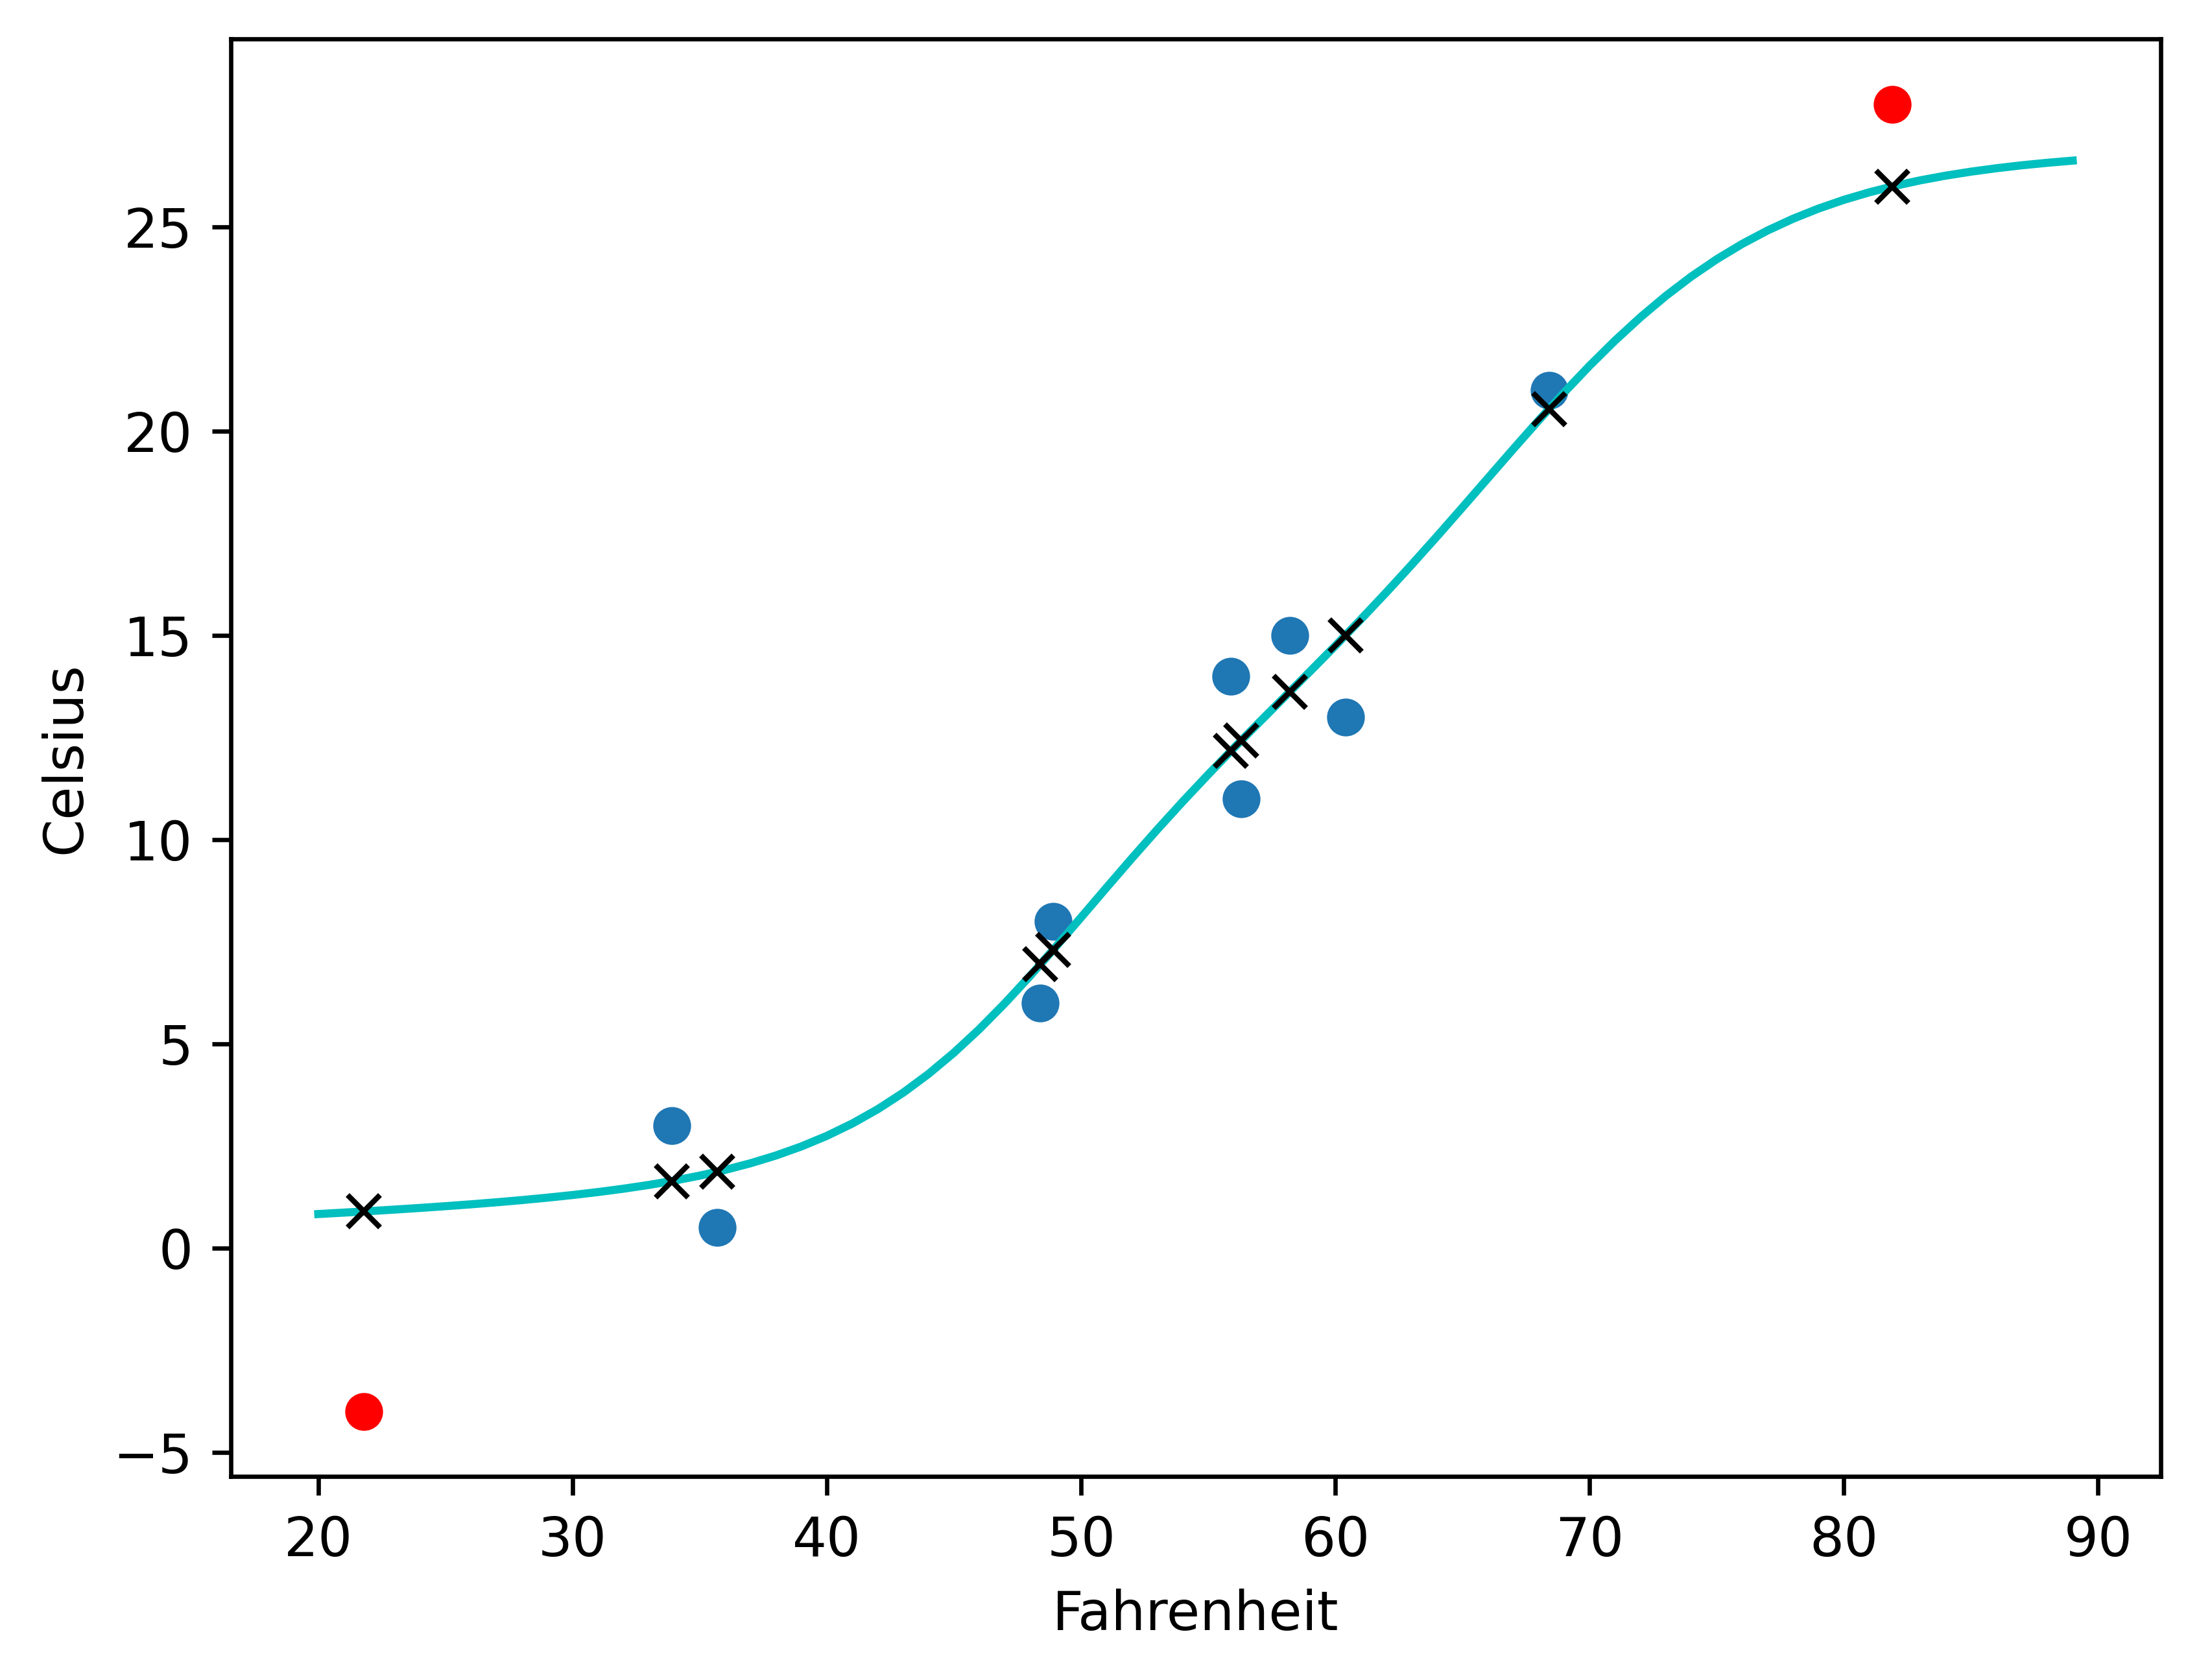

In [62]:
from matplotlib import pyplot as plt
t_range = torch.arange(20., 90.).unsqueeze(1)
fig = plt.figure(dpi=600)

plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(train_t_u.numpy(), train_t_c.numpy(), 'o')
plt.plot(val_t_u.numpy(), val_t_c.numpy(), 'ro')
plt.plot(t_range.numpy(), seq_model((t_range - t_u_mean)/t_u_std).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(t_un.unsqueeze(1)).detach().numpy(), 'kx')

linia trendu wydaje się dobrze pasować do reszty punktów danych.

Linia trendu przy wiekszej liczbie neuronow i funkcji aktywacyjnej relu może sprawic ze krzywa jest troche bardziej zlozona, lepiej uwzglednia outliersy, z uwagi na dokladniejsze dopasowanie sie modelu, ale trzeba uwazac na overfitting, gdy zmniejszamy liczbe neuronow model wiec i krzywa sie upraszczaja. funkcje aktywacji wplywaja na to jak dane są przekształcane, relu lepiej wykrywa nieliniowe zależnosci niz sigmoidalna

Wnioski:

* nn.Sequential jest przydatnym narzędziem do budowania sieci neuronowych zarówno prostych jak i złożonych z wielu warstw ukrytych
* optymalizator SGD służy do aktualizacji parametrów na podstawie funkcji straty
* różne funkcje aktywacji i liczba neuronów wpływają na wydajność modelu, by maksymalnie zwiększyć wydajność należy eksperymentować.